# **BERT to Analyze Twitter Data**

In this session, we will talk about the working of BERT along with the different methodologies involved and will implement twitter sentiment analysis using the BERT model.

To read about it more, please go through [this](https://analyticsindiamag.com/how-i-used-bidirectional-encoder-representations-from-transformers-bert-to-analyze-twitter-data/) article.

## **Implementation of BERT to Analyze Twitter Data**

Let us consider a simple dataset like twitter sentiment analysis data for the implementation of BERT.

Checking for GPU :

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('Using CPU.')
    device = torch.device("cpu")

Using CPU.


Installing the transformer:

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 6.9MB/s 
     |████████████████████████████████| 3.3MB 40.1MB/s 
     |████████████████████████████████| 901kB 41.6MB/s 


Loading the data and converting it to NumPy array:

In [ ]:
import numpy as np
import pandas as pd

tweet_train=pd.read_csv('https://raw.githubusercontent.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/master/Data/train_tweets.csv')

In [ ]:
tweets = tweet_train.tweet.values
labels = tweet_train.label.values

Now, we will initialize the BERT tokenizer and convert each word to a unique token. Here we use a method called encode which helps in combining multiple steps. The method splits the sentences to tokens, adds the [cls] and [sep] tokens and also matches the tokens to id.

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tweetid = []
for tweet in tweets:
  encoded_tweet = tokenizer.encode(tweet,add_special_tokens = True,)
  tweetid.append(encoded_tweet)

print('Original: ', tweets[0])
print('Token IDs:', tweetid[0])



Original:   @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Token IDs: [101, 1030, 5310, 2043, 1037, 2269, 2003, 28466, 2389, 1998, 2003, 2061, 14337, 2002, 8011, 2015, 2010, 4268, 2046, 2010, 28466, 1012, 1001, 2448, 102]


Next, we will truncate the sentences so that all the sentences have the same length.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 64
print('\n Truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
tweetid = pad_sequences(tweetid, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")


 Truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0


The final step before the training begins is to create masks in the input.

In [ ]:
masks = []
for tweet in tweetid:
  mask = [int(token_id > 0) for token_id in tweet]
  masks.append(mask)

Let us first split the data into training and validation set.

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(tweetid, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(masks, labels, random_state=2018, test_size=0.1)

Now, since we are implementing this in PyTorch we will convert the data into tensors.

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

We will use the pre-trained BERT sequence classifier model on our data and Adam optimizer. We will set the learning rate to a very small value and initialize a scheduler.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cpu()
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training and evaluation:

In [ ]:
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  total_loss = 0
  model.train()
  for step, batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels)

    loss = outputs[0]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("validation")

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

======== Epoch 1 / 4 ========
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.00
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.01
validation
  Average training loss: 0.

In [ ]:
#Graph:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
BERT to Analyze Twitter Data

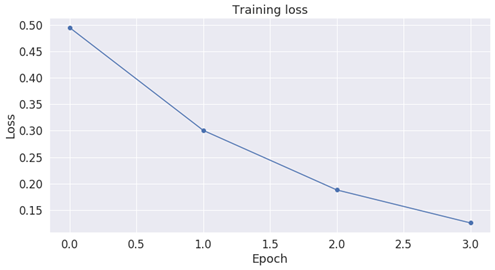

The results indicate that the accuracy for the BERT model is 97% which means the model performed well even on small datasets. The model has not overfitted as we can see no sharp spike in the graph shown above.

Testing

Let us see how our model performed on test data.

In [ ]:
tweet_test=pd.read_csv('https://raw.githubusercontent.com/bhoomikamadhukar/NLP/master/test.csv')

We will have to perform the same processing techniques as we did for training here as well.

In [ ]:
tweetvalidation = tweet_test.tweet.values
labels=tweet_test.label.values
test_id = []

for tweet in tweetvalidation:
    encoded_tweet = tokenizer.encode(
                        tweet,
                        add_special_tokens = True,
                   )
    test_id.append(encoded_tweet)
test_id = pad_sequences(test_id, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in test_id:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
prediction_inputs = torch.tensor(test_id)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

from sklearn.metrics import classification_report
for i in range(len(true_labels)):
  pred_labels_flattening = np.argmax(predictions[i], axis=1).flatten()
print(classification_report(true_labels[0], pred_labels_flattening) )

Thus we can see that within a short period of time we can build a BERT model that works on test data with a fairly good score.

# **Related Articles:**

> * [BERT to Analyze Twitter Data ](https://analyticsindiamag.com/how-i-used-bidirectional-encoder-representations-from-transformers-bert-to-analyze-twitter-data/)

> * [Language Modelling using Unigram](https://analyticsindiamag.com/complete-guide-on-language-modelling-unigram-using-python/)

> * [Predict the News Category](https://analyticsindiamag.com/guide-to-cracking-machinehacks-predict-the-news-category-hackathon/)

> * [Guide to Sense2vec](https://analyticsindiamag.com/guide-to-sense2vec-contextually-keyed-word-vectors-for-nlp/)

> * [Download Twitter Data and Analyze](https://analyticsindiamag.com/hands-on-guide-to-download-analyze-and-visualize-twitter-data/)

> * [Sentiment Analysis using LSTM](https://analyticsindiamag.com/how-to-implement-lstm-rnn-network-for-sentiment-analysis/)